# DefaultBART Grid Search Analysis: Multiple Parameter Combinations on Friedman Dataset

This notebook performs a comprehensive grid search analysis of DefaultBART performance across different combinations of:
- `bart_num` (number of chains)
- `TOTAL_BUDGET` (total computational budget)
- `RATIO_TARGET` (ratio of n_post/n_skip)

Results are visualized as colored heatmaps showing MSE and Coverage performance on the Friedman regression dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from bart_playground import *
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Grid search parameters
BART_NUMS = [1, 3, 4, 5]
TOTAL_BUDGETS = [120, 160, 240]
RATIO_TARGETS = [0.05, 0.1, 0.25, 1, 4, 10, 20]

# Fixed parameters
N_TREES = 100
RANDOM_STATE = 42
PROPOSAL_PROBS = {"grow": 0.5, "prune": 0.5}

np.random.seed(RANDOM_STATE)

print(f"Grid search dimensions:")
print(f"BART_NUMS: {len(BART_NUMS)} values {BART_NUMS}")
print(f"TOTAL_BUDGETS: {len(TOTAL_BUDGETS)} values {TOTAL_BUDGETS}")
print(f"RATIO_TARGETS: {len(RATIO_TARGETS)} values {RATIO_TARGETS}")
print(f"Total combinations: {len(BART_NUMS) * len(TOTAL_BUDGETS) * len(RATIO_TARGETS)}")

Grid search dimensions:
BART_NUMS: 4 values [1, 3, 4, 5]
TOTAL_BUDGETS: 3 values [120, 160, 240]
RATIO_TARGETS: 7 values [0.05, 0.1, 0.25, 1, 4, 10, 20]
Total combinations: 84


In [3]:
from joblib import Parallel, delayed

def fit_and_predict(seed, X_train, y_train, X_test, n_trees, ndpost, nskip, proposal_probs):
    """Fit a single BART model and return predictions"""
    model = DefaultBART(
        ndpost=ndpost,
        nskip=nskip,
        n_trees=n_trees,
        proposal_probs=proposal_probs,
        random_state=seed
    )
    model.fit(X_train, y_train)
    posterior_pred = model.posterior_predict(X_test)
    posterior_f = model.posterior_f(X_test)
    return posterior_pred, posterior_f

def evaluate_default_bart(bart_num, total_budget, ratio_target, X_train, X_test, y_train, y_test):
    """Evaluate DefaultBART with given parameters"""
    
    # Calculate n_post and n_skip
    total_per_bart = total_budget // bart_num
    n_skip = int(total_per_bart / (ratio_target + 1))
    n_post = total_per_bart - n_skip
    
    # Skip invalid configurations
    if n_post <= 0 or n_skip <= 0:
        return None
    
    try:
        # Run parallel BART models
        results = Parallel(n_jobs=-1)(
            delayed(fit_and_predict)(
                i, X_train, y_train, X_test,
                N_TREES, n_post, n_skip, PROPOSAL_PROBS
            )
            for i in range(bart_num)
        )
        
        # Combine results from all chains
        all_posterior_pred = []
        all_posterior_f = []
        
        for posterior_pred, posterior_f in results:
            all_posterior_pred.append(posterior_pred)
            all_posterior_f.append(posterior_f)
        
        # Concatenate predictions across chains
        combined_posterior_pred = np.concatenate(all_posterior_pred, axis=1)
        combined_posterior_f = np.concatenate(all_posterior_f, axis=1)
        
        # Calculate metrics
        posterior_mean = np.mean(combined_posterior_f, axis=1)
        mse = mean_squared_error(y_test, posterior_mean)
        
        # Calculate prediction intervals and coverage
        bart_lower = np.percentile(combined_posterior_pred, 2.5, axis=1)
        bart_upper = np.percentile(combined_posterior_pred, 97.5, axis=1)
        pi_length = np.mean(bart_upper - bart_lower)
        coverage = ((y_test >= bart_lower) & (y_test <= bart_upper)).mean()
        
        return {
            'bart_num': bart_num,
            'total_budget': total_budget,
            'ratio_target': ratio_target,
            'n_post': n_post,
            'n_skip': n_skip,
            'mse': mse,
            'pi_length': pi_length,
            'coverage': coverage,
            'actual_budget': (n_post + n_skip) * bart_num
        }
        
    except Exception as e:
        print(f"Error with bart_num={bart_num}, budget={total_budget}, ratio={ratio_target}: {e}")
        return None

In [4]:
# Load and prepare Friedman dataset
print("Generating Friedman dataset...")
generator = DataGenerator(n_samples=1000, n_features=5, noise=1, random_seed=RANDOM_STATE)
X, y = generator.generate(scenario="friedman1")

print(f"Dataset shape: X={X.shape}, y={y.shape}")
print(f"y statistics: mean={y.mean():.3f}, std={y.std():.3f}, min={y.min():.3f}, max={y.max():.3f}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.8, random_state=RANDOM_STATE
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Generating Friedman dataset...
Dataset shape: X=(1000, 5), y=(1000,)
y statistics: mean=14.342, std=5.099, min=0.354, max=28.031
Training set: 200 samples
Test set: 800 samples


In [5]:
# Perform grid search
print("\n=== Starting Grid Search ===")
results = []
total_combinations = len(BART_NUMS) * len(TOTAL_BUDGETS) * len(RATIO_TARGETS)
current_combination = 0

start_time = time.time()

for bart_num, total_budget, ratio_target in product(BART_NUMS, TOTAL_BUDGETS, RATIO_TARGETS):
    current_combination += 1
    
    print(f"Progress: {current_combination}/{total_combinations} - "
          f"bart_num={bart_num}, budget={total_budget}, ratio={ratio_target}")
    
    result = evaluate_default_bart(bart_num, total_budget, ratio_target, 
                                  X_train, X_test, y_train, y_test)
    
    if result is not None:
        results.append(result)

total_time = time.time() - start_time
print(f"\nGrid search completed in {total_time:.2f} seconds")
print(f"Valid configurations: {len(results)}/{total_combinations}")


=== Starting Grid Search ===
Progress: 1/84 - bart_num=1, budget=120, ratio=0.05


Iterations: 100%|██████████| 120/120 [00:06<00:00, 17.57it/s]


Progress: 2/84 - bart_num=1, budget=120, ratio=0.1


Iterations: 100%|██████████| 120/120 [00:06<00:00, 17.65it/s]


Progress: 3/84 - bart_num=1, budget=120, ratio=0.25


Iterations: 100%|██████████| 120/120 [00:06<00:00, 17.43it/s]


Progress: 4/84 - bart_num=1, budget=120, ratio=1


Iterations: 100%|██████████| 120/120 [00:06<00:00, 17.49it/s]


Progress: 5/84 - bart_num=1, budget=120, ratio=4


Iterations: 100%|██████████| 120/120 [00:06<00:00, 17.52it/s]


Progress: 6/84 - bart_num=1, budget=120, ratio=10


Iterations: 100%|██████████| 120/120 [00:06<00:00, 17.26it/s]


Progress: 7/84 - bart_num=1, budget=120, ratio=20


Iterations: 100%|██████████| 120/120 [00:07<00:00, 16.91it/s]


Progress: 8/84 - bart_num=1, budget=160, ratio=0.05


Iterations:   6%|▋         | 10/160 [00:00<00:01, 92.12it/s]

Progress: 9/84 - bart_num=1, budget=160, ratio=0.1


Iterations: 100%|██████████| 160/160 [00:02<00:00, 63.00it/s]


Progress: 10/84 - bart_num=1, budget=160, ratio=0.25


Iterations: 100%|██████████| 160/160 [00:01<00:00, 84.28it/s]


Progress: 11/84 - bart_num=1, budget=160, ratio=1


Iterations: 100%|██████████| 160/160 [00:01<00:00, 86.24it/s]


Progress: 12/84 - bart_num=1, budget=160, ratio=4


Iterations: 100%|██████████| 160/160 [00:01<00:00, 85.12it/s]


Progress: 13/84 - bart_num=1, budget=160, ratio=10


Iterations: 100%|██████████| 160/160 [00:01<00:00, 87.14it/s]


Progress: 14/84 - bart_num=1, budget=160, ratio=20


Iterations: 100%|██████████| 160/160 [00:01<00:00, 85.99it/s]


Progress: 15/84 - bart_num=1, budget=240, ratio=0.05


Iterations:   0%|          | 0/240 [00:00<?, ?it/s]

Progress: 16/84 - bart_num=1, budget=240, ratio=0.1


Iterations: 100%|██████████| 240/240 [00:02<00:00, 87.42it/s]


Progress: 17/84 - bart_num=1, budget=240, ratio=0.25


Iterations: 100%|██████████| 240/240 [00:02<00:00, 85.92it/s]


Progress: 18/84 - bart_num=1, budget=240, ratio=1


Iterations: 100%|██████████| 240/240 [00:02<00:00, 83.56it/s]


Progress: 19/84 - bart_num=1, budget=240, ratio=4


Iterations: 100%|██████████| 240/240 [00:02<00:00, 86.79it/s]


Progress: 20/84 - bart_num=1, budget=240, ratio=10


Iterations: 100%|██████████| 240/240 [00:02<00:00, 84.76it/s]


Progress: 21/84 - bart_num=1, budget=240, ratio=20


Iterations: 100%|██████████| 240/240 [00:02<00:00, 87.70it/s]


Progress: 22/84 - bart_num=3, budget=120, ratio=0.05


Iterations:  25%|██▌       | 10/40 [00:00<00:00, 90.29it/s]

Progress: 23/84 - bart_num=3, budget=120, ratio=0.1


Iterations:  25%|██▌       | 10/40 [00:00<00:00, 92.73it/s]

Progress: 24/84 - bart_num=3, budget=120, ratio=0.25


Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

Progress: 25/84 - bart_num=3, budget=120, ratio=1


Iterations: 100%|██████████| 40/40 [00:00<00:00, 84.33it/s]


Progress: 26/84 - bart_num=3, budget=120, ratio=4


Iterations: 100%|██████████| 40/40 [00:00<00:00, 84.25it/s]


Progress: 27/84 - bart_num=3, budget=120, ratio=10


Iterations: 100%|██████████| 40/40 [00:00<00:00, 85.02it/s]


Progress: 28/84 - bart_num=3, budget=120, ratio=20


Iterations: 100%|██████████| 40/40 [00:00<00:00, 83.42it/s]


Progress: 29/84 - bart_num=3, budget=160, ratio=0.05


Iterations:  19%|█▉        | 10/53 [00:00<00:00, 91.52it/s]

Progress: 30/84 - bart_num=3, budget=160, ratio=0.1


Iterations: 100%|██████████| 53/53 [00:00<00:00, 81.95it/s]


Progress: 31/84 - bart_num=3, budget=160, ratio=0.25


Iterations: 100%|██████████| 53/53 [00:00<00:00, 85.53it/s]


Progress: 32/84 - bart_num=3, budget=160, ratio=1


Iterations: 100%|██████████| 53/53 [00:00<00:00, 84.43it/s]


Progress: 33/84 - bart_num=3, budget=160, ratio=4


Iterations: 100%|██████████| 53/53 [00:00<00:00, 82.70it/s]


Progress: 34/84 - bart_num=3, budget=160, ratio=10


Iterations: 100%|██████████| 53/53 [00:00<00:00, 86.10it/s]


Progress: 35/84 - bart_num=3, budget=160, ratio=20


Iterations: 100%|██████████| 53/53 [00:00<00:00, 83.26it/s]


Progress: 36/84 - bart_num=3, budget=240, ratio=0.05


Iterations:   0%|          | 0/80 [00:00<?, ?it/s]

Progress: 37/84 - bart_num=3, budget=240, ratio=0.1


Iterations:   0%|          | 0/80 [00:00<?, ?it/s]

Progress: 38/84 - bart_num=3, budget=240, ratio=0.25


Iterations:   0%|          | 0/80 [00:00<?, ?it/s]

Progress: 39/84 - bart_num=3, budget=240, ratio=1


Iterations: 100%|██████████| 80/80 [00:00<00:00, 80.92it/s]


Progress: 40/84 - bart_num=3, budget=240, ratio=4


Iterations: 100%|██████████| 80/80 [00:01<00:00, 77.68it/s]


Progress: 41/84 - bart_num=3, budget=240, ratio=10


Iterations: 100%|██████████| 80/80 [00:00<00:00, 83.18it/s]


Progress: 42/84 - bart_num=3, budget=240, ratio=20


Iterations: 100%|██████████| 80/80 [00:00<00:00, 85.35it/s]


Progress: 43/84 - bart_num=4, budget=120, ratio=0.05


Iterations:   0%|          | 0/30 [00:00<?, ?it/s]

Progress: 44/84 - bart_num=4, budget=120, ratio=0.1


Iterations:   0%|          | 0/30 [00:00<?, ?it/s]

Progress: 45/84 - bart_num=4, budget=120, ratio=0.25


Iterations:   0%|          | 0/30 [00:00<?, ?it/s]

Progress: 46/84 - bart_num=4, budget=120, ratio=1


Iterations:   0%|          | 0/30 [00:00<?, ?it/s]

Progress: 47/84 - bart_num=4, budget=120, ratio=4


Iterations: 100%|██████████| 30/30 [00:00<00:00, 78.61it/s]


Progress: 48/84 - bart_num=4, budget=120, ratio=10


Iterations: 100%|██████████| 30/30 [00:00<00:00, 77.62it/s]


Progress: 49/84 - bart_num=4, budget=120, ratio=20


Iterations: 100%|██████████| 30/30 [00:00<00:00, 81.20it/s]


Progress: 50/84 - bart_num=4, budget=160, ratio=0.05


Iterations:  25%|██▌       | 10/40 [00:00<00:00, 89.21it/s]

Progress: 51/84 - bart_num=4, budget=160, ratio=0.1


Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

Progress: 52/84 - bart_num=4, budget=160, ratio=0.25


Iterations: 100%|██████████| 40/40 [00:00<00:00, 81.75it/s]


Progress: 53/84 - bart_num=4, budget=160, ratio=1


Iterations: 100%|██████████| 40/40 [00:00<00:00, 79.89it/s]


Progress: 54/84 - bart_num=4, budget=160, ratio=4


Iterations: 100%|██████████| 40/40 [00:00<00:00, 82.65it/s]


Progress: 55/84 - bart_num=4, budget=160, ratio=10


Iterations: 100%|██████████| 40/40 [00:00<00:00, 83.17it/s]


Progress: 56/84 - bart_num=4, budget=160, ratio=20


Iterations: 100%|██████████| 40/40 [00:00<00:00, 81.41it/s]


Progress: 57/84 - bart_num=4, budget=240, ratio=0.05


Iterations:   0%|          | 0/60 [00:00<?, ?it/s]

Progress: 58/84 - bart_num=4, budget=240, ratio=0.1


Iterations:  17%|█▋        | 10/60 [00:00<00:00, 89.81it/s]

Progress: 59/84 - bart_num=4, budget=240, ratio=0.25


Iterations: 100%|██████████| 60/60 [00:00<00:00, 77.14it/s]


Progress: 60/84 - bart_num=4, budget=240, ratio=1


Iterations: 100%|██████████| 60/60 [00:00<00:00, 79.14it/s]


Progress: 61/84 - bart_num=4, budget=240, ratio=4


Iterations: 100%|██████████| 60/60 [00:00<00:00, 81.64it/s]


Progress: 62/84 - bart_num=4, budget=240, ratio=10


Iterations: 100%|██████████| 60/60 [00:00<00:00, 80.50it/s]


Progress: 63/84 - bart_num=4, budget=240, ratio=20


Iterations: 100%|██████████| 60/60 [00:00<00:00, 81.74it/s]


Progress: 64/84 - bart_num=5, budget=120, ratio=0.05


Iterations:  25%|██▌       | 6/24 [00:00<00:00, 53.47it/s]

Progress: 65/84 - bart_num=5, budget=120, ratio=0.1


Iterations:  25%|██▌       | 6/24 [00:00<00:00, 54.30it/s]]

Progress: 66/84 - bart_num=5, budget=120, ratio=0.25


Iterations:  25%|██▌       | 6/24 [00:00<00:00, 52.59it/s]]

Progress: 67/84 - bart_num=5, budget=120, ratio=1


Iterations:   0%|          | 0/24 [00:00<?, ?it/s]

Progress: 68/84 - bart_num=5, budget=120, ratio=4


Iterations: 100%|██████████| 24/24 [00:00<00:00, 48.86it/s]


Progress: 69/84 - bart_num=5, budget=120, ratio=10


Iterations: 100%|██████████| 24/24 [00:00<00:00, 49.36it/s]


Progress: 70/84 - bart_num=5, budget=120, ratio=20


Iterations: 100%|██████████| 24/24 [00:00<00:00, 47.85it/s]


Progress: 71/84 - bart_num=5, budget=160, ratio=0.05


Iterations:   0%|          | 0/32 [00:00<?, ?it/s]

Progress: 72/84 - bart_num=5, budget=160, ratio=0.1


Iterations:  19%|█▉        | 6/32 [00:00<00:00, 52.37it/s]

Progress: 73/84 - bart_num=5, budget=160, ratio=0.25


Iterations: 100%|██████████| 32/32 [00:00<00:00, 51.23it/s]


Progress: 74/84 - bart_num=5, budget=160, ratio=1


Iterations:   0%|          | 0/32 [00:00<?, ?it/s]

Progress: 75/84 - bart_num=5, budget=160, ratio=4


Iterations: 100%|██████████| 32/32 [00:00<00:00, 49.32it/s]


Progress: 76/84 - bart_num=5, budget=160, ratio=10


Iterations: 100%|██████████| 32/32 [00:00<00:00, 47.53it/s]


Progress: 77/84 - bart_num=5, budget=160, ratio=20


Iterations: 100%|██████████| 32/32 [00:00<00:00, 48.27it/s]


Progress: 78/84 - bart_num=5, budget=240, ratio=0.05


Iterations:  12%|█▎        | 6/48 [00:00<00:00, 53.14it/s]]

Progress: 79/84 - bart_num=5, budget=240, ratio=0.1


Iterations: 100%|██████████| 48/48 [00:00<00:00, 55.50it/s]


Progress: 80/84 - bart_num=5, budget=240, ratio=0.25


Iterations:   0%|          | 0/48 [00:00<?, ?it/s]

Progress: 81/84 - bart_num=5, budget=240, ratio=1


Iterations: 100%|██████████| 48/48 [00:00<00:00, 50.90it/s]


Progress: 82/84 - bart_num=5, budget=240, ratio=4


Iterations: 100%|██████████| 48/48 [00:01<00:00, 47.66it/s]


Progress: 83/84 - bart_num=5, budget=240, ratio=10


Iterations: 100%|██████████| 48/48 [00:01<00:00, 47.45it/s]


Progress: 84/84 - bart_num=5, budget=240, ratio=20


Iterations: 100%|██████████| 48/48 [00:01<00:00, 47.43it/s]



Grid search completed in 162.11 seconds
Valid configurations: 84/84


In [6]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

print("\n=== Grid Search Results Summary ===")
print(f"Total valid configurations: {len(results_df)}")
print(f"MSE range: {results_df['mse'].min():.4f} - {results_df['mse'].max():.4f}")
print(f"Coverage range: {results_df['coverage'].min():.4f} - {results_df['coverage'].max():.4f}")
print(f"PI Length range: {results_df['pi_length'].min():.4f} - {results_df['pi_length'].max():.4f}")

print("\nBest configurations:")
best_mse = results_df.loc[results_df['mse'].idxmin()]
best_coverage = results_df.loc[(results_df['coverage'] - 0.95).abs().idxmin()]

print(f"Best MSE: {best_mse['mse']:.4f}")
print(f"  bart_num={best_mse['bart_num']}, budget={best_mse['total_budget']}, ratio={best_mse['ratio_target']}")

print(f"Best Coverage (closest to 95%): {best_coverage['coverage']:.4f}")
print(f"  bart_num={best_coverage['bart_num']}, budget={best_coverage['total_budget']}, ratio={best_coverage['ratio_target']}")


=== Grid Search Results Summary ===
Total valid configurations: 84
MSE range: 1.9930 - 3.1077
Coverage range: 0.5625 - 0.9812
PI Length range: 2.8836 - 7.9530

Best configurations:
Best MSE: 1.9930
  bart_num=1.0, budget=240.0, ratio=10.0
Best Coverage (closest to 95%): 0.9500
  bart_num=4.0, budget=160.0, ratio=1.0


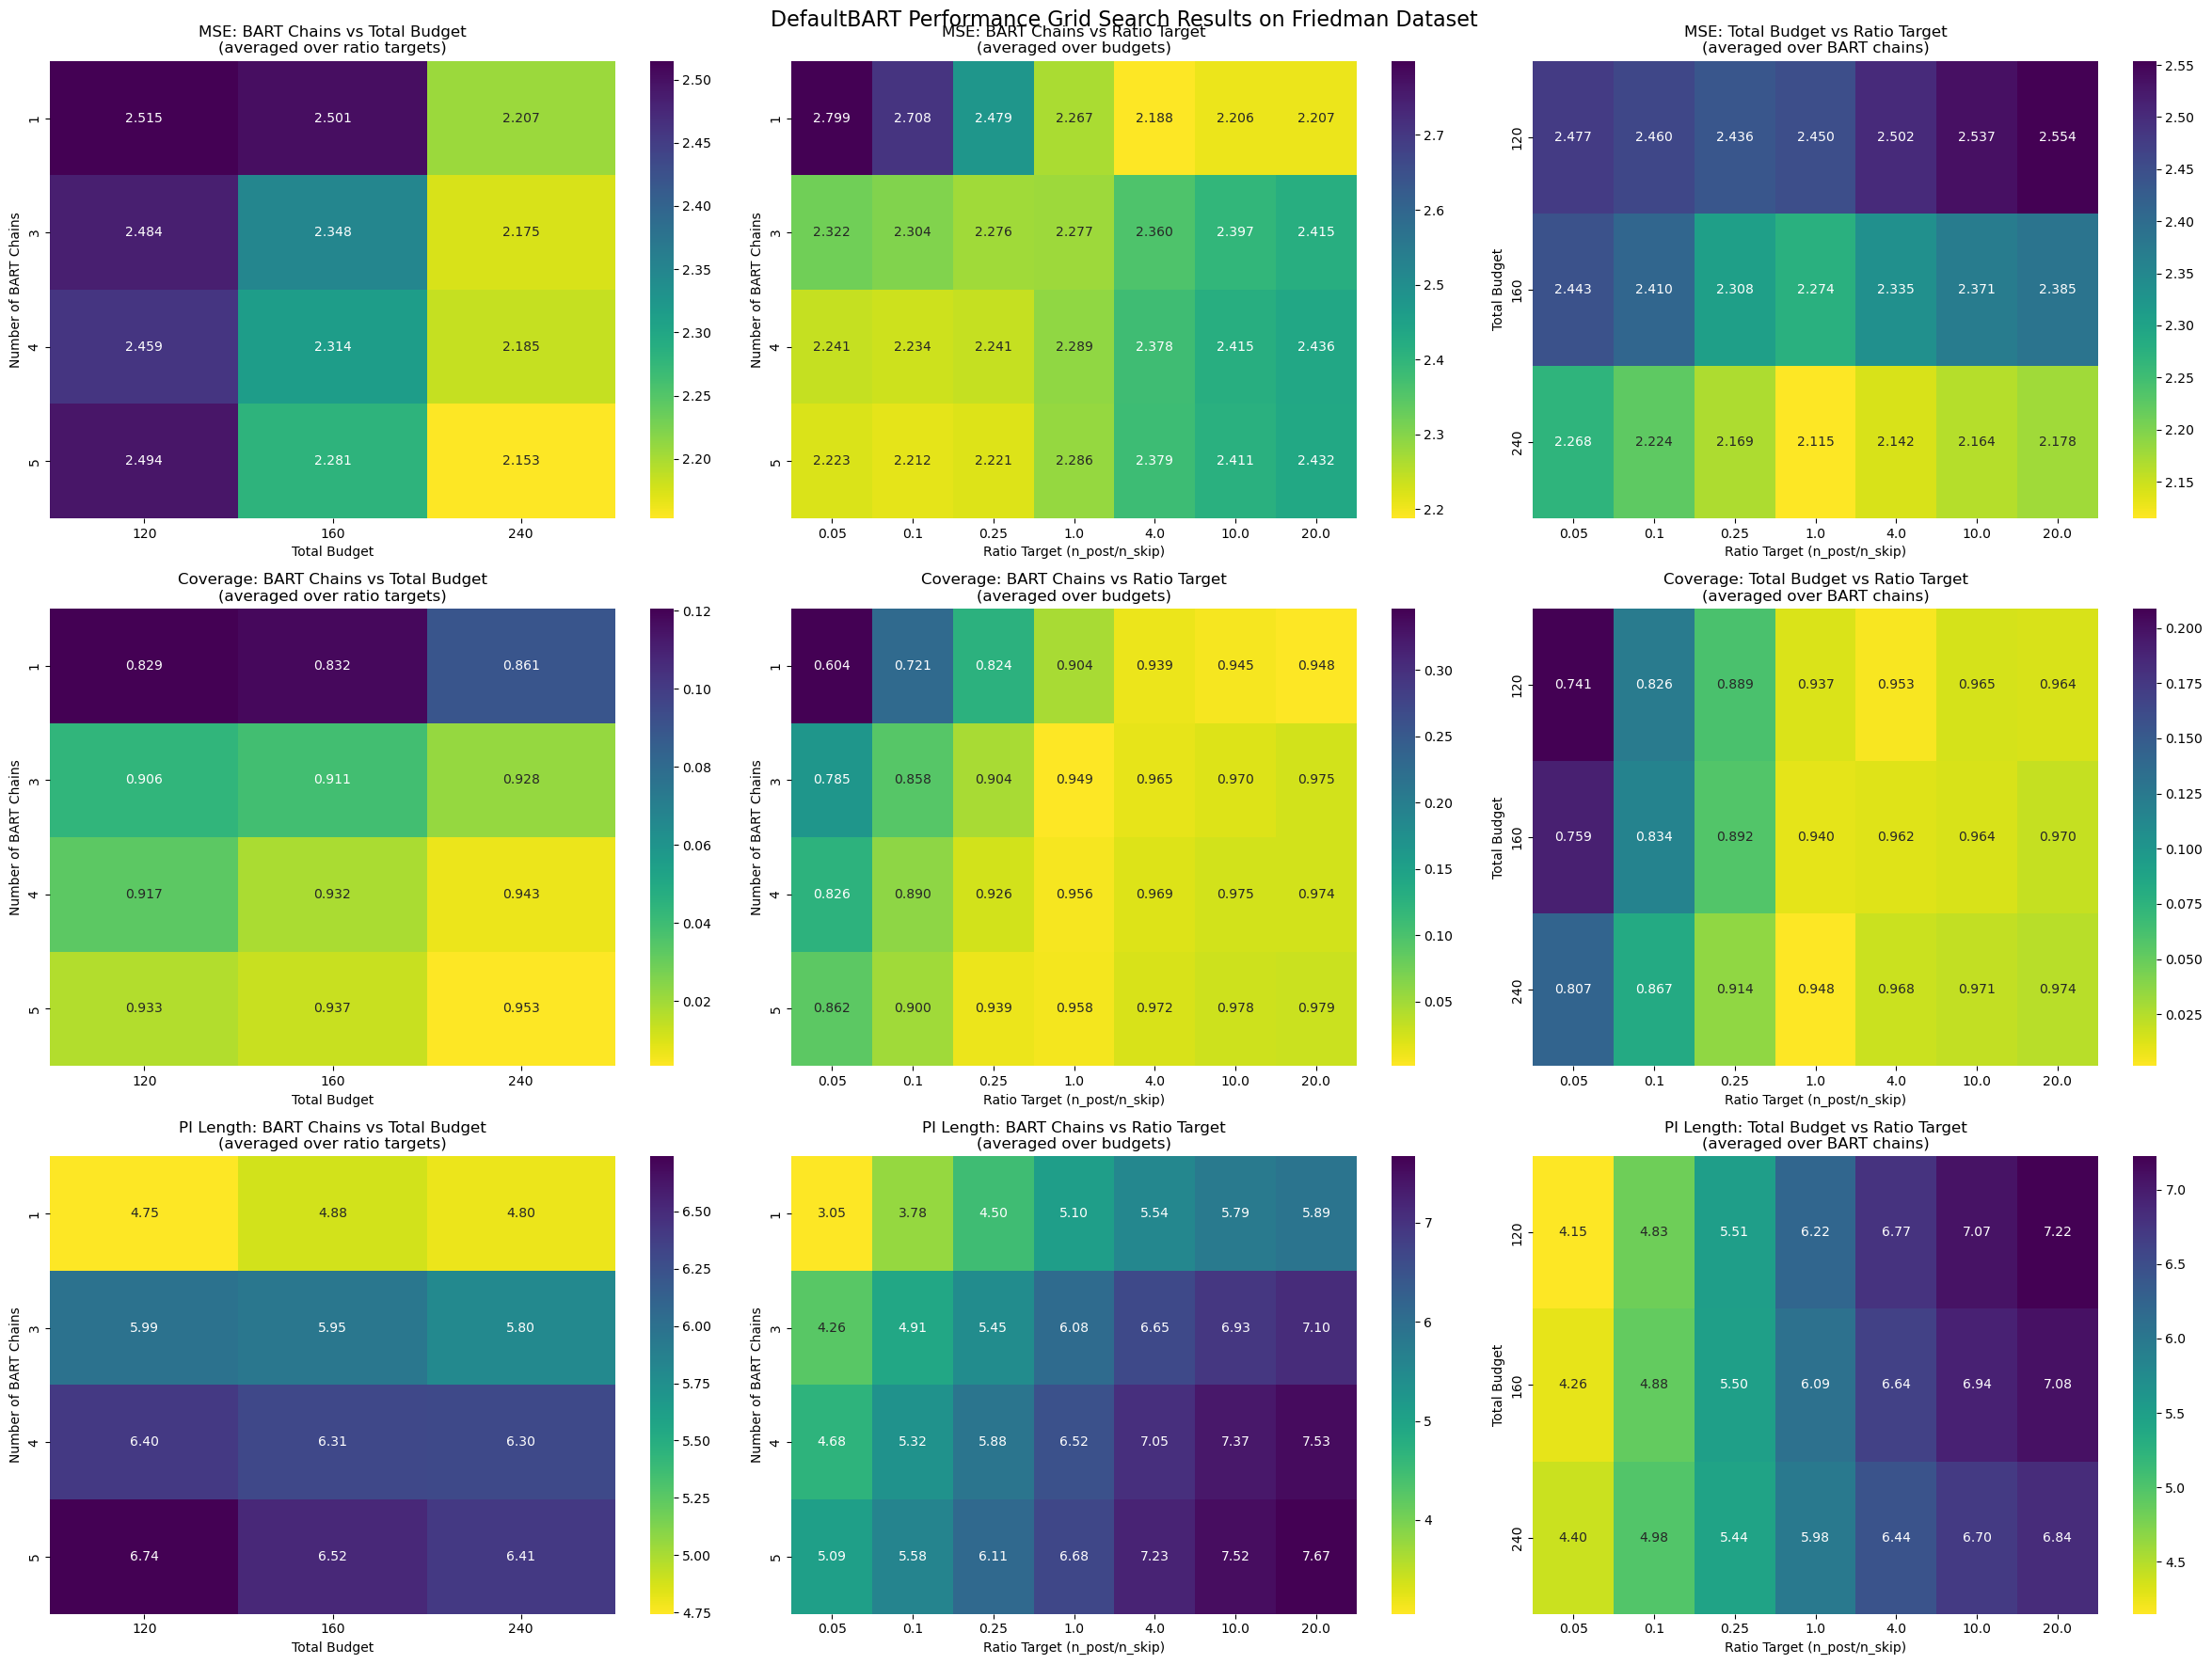

In [30]:
# Create heatmaps for different perspectives
from numpy import diff


fig, axes = plt.subplots(3, 3, figsize=(24, 18))
fig.suptitle('DefaultBART Performance Grid Search Results on Friedman Dataset', fontsize=16)

# Row 1: MSE heatmaps
# 1. MSE: bart_num vs total_budget (averaged over ratio_target)
mse_pivot1 = results_df.groupby(['bart_num', 'total_budget'])['mse'].mean().unstack()
sns.heatmap(mse_pivot1, annot=True, fmt='.3f', cmap='viridis_r', ax=axes[0,0])
axes[0,0].set_title('MSE: BART Chains vs Total Budget\n(averaged over ratio targets)')
axes[0,0].set_xlabel('Total Budget')
axes[0,0].set_ylabel('Number of BART Chains')

# 2. MSE: bart_num vs ratio_target (averaged over total_budget)
mse_pivot2 = results_df.groupby(['bart_num', 'ratio_target'])['mse'].mean().unstack()
sns.heatmap(mse_pivot2, annot=True, fmt='.3f', cmap='viridis_r', ax=axes[0,1])
axes[0,1].set_title('MSE: BART Chains vs Ratio Target\n(averaged over budgets)')
axes[0,1].set_xlabel('Ratio Target (n_post/n_skip)')
axes[0,1].set_ylabel('Number of BART Chains')

# 3. MSE: total_budget vs ratio_target (averaged over bart_num)
mse_pivot3 = results_df.groupby(['total_budget', 'ratio_target'])['mse'].mean().unstack()
sns.heatmap(mse_pivot3, annot=True, fmt='.3f', cmap='viridis_r', ax=axes[0,2])
axes[0,2].set_title('MSE: Total Budget vs Ratio Target\n(averaged over BART chains)')
axes[0,2].set_xlabel('Ratio Target (n_post/n_skip)')
axes[0,2].set_ylabel('Total Budget')

# Row 2: Coverage heatmaps
# 4. Coverage: bart_num vs total_budget (averaged over ratio_target)
cov_pivot1 = results_df.groupby(['bart_num', 'total_budget'])['coverage'].mean().unstack()
diff_1 = (cov_pivot1 - 0.95).abs()
sns.heatmap(diff_1, annot=cov_pivot1, fmt='.3f', cmap='viridis_r', ax=axes[1,0])
axes[1,0].set_title('Coverage: BART Chains vs Total Budget\n(averaged over ratio targets)')
axes[1,0].set_xlabel('Total Budget')
axes[1,0].set_ylabel('Number of BART Chains')

# 5. Coverage: bart_num vs ratio_target (averaged over total_budget)
cov_pivot2 = results_df.groupby(['bart_num', 'ratio_target'])['coverage'].mean().unstack()
diff_2 = (cov_pivot2 - 0.95).abs()
sns.heatmap(diff_2, annot=cov_pivot2, fmt='.3f', cmap='viridis_r', ax=axes[1,1])
axes[1,1].set_title('Coverage: BART Chains vs Ratio Target\n(averaged over budgets)')
axes[1,1].set_xlabel('Ratio Target (n_post/n_skip)')
axes[1,1].set_ylabel('Number of BART Chains')

# 6. Coverage: total_budget vs ratio_target (averaged over bart_num)
cov_pivot3 = results_df.groupby(['total_budget', 'ratio_target'])['coverage'].mean().unstack()
diff_3 = (cov_pivot3 - 0.95).abs()
sns.heatmap(diff_3, annot=cov_pivot3, fmt='.3f', cmap='viridis_r', ax=axes[1,2])
axes[1,2].set_title('Coverage: Total Budget vs Ratio Target\n(averaged over BART chains)')
axes[1,2].set_xlabel('Ratio Target (n_post/n_skip)')
axes[1,2].set_ylabel('Total Budget')

# Row 3: PI Length heatmaps
# 7. PI Length: bart_num vs total_budget (averaged over ratio_target)
pi_pivot1 = results_df.groupby(['bart_num', 'total_budget'])['pi_length'].mean().unstack()
sns.heatmap(pi_pivot1, annot=True, fmt='.2f', cmap='viridis_r', ax=axes[2,0])
axes[2,0].set_title('PI Length: BART Chains vs Total Budget\n(averaged over ratio targets)')
axes[2,0].set_xlabel('Total Budget')
axes[2,0].set_ylabel('Number of BART Chains')

# 8. PI Length: bart_num vs ratio_target (averaged over total_budget)
pi_pivot2 = results_df.groupby(['bart_num', 'ratio_target'])['pi_length'].mean().unstack()
sns.heatmap(pi_pivot2, annot=True, fmt='.2f', cmap='viridis_r', ax=axes[2,1])
axes[2,1].set_title('PI Length: BART Chains vs Ratio Target\n(averaged over budgets)')
axes[2,1].set_xlabel('Ratio Target (n_post/n_skip)')
axes[2,1].set_ylabel('Number of BART Chains')

# 9. PI Length: total_budget vs ratio_target (averaged over bart_num)
pi_pivot3 = results_df.groupby(['total_budget', 'ratio_target'])['pi_length'].mean().unstack()
sns.heatmap(pi_pivot3, annot=True, fmt='.2f', cmap='viridis_r', ax=axes[2,2])
axes[2,2].set_title('PI Length: Total Budget vs Ratio Target\n(averaged over BART chains)')
axes[2,2].set_xlabel('Ratio Target (n_post/n_skip)')
axes[2,2].set_ylabel('Total Budget')

plt.tight_layout()
plt.show()

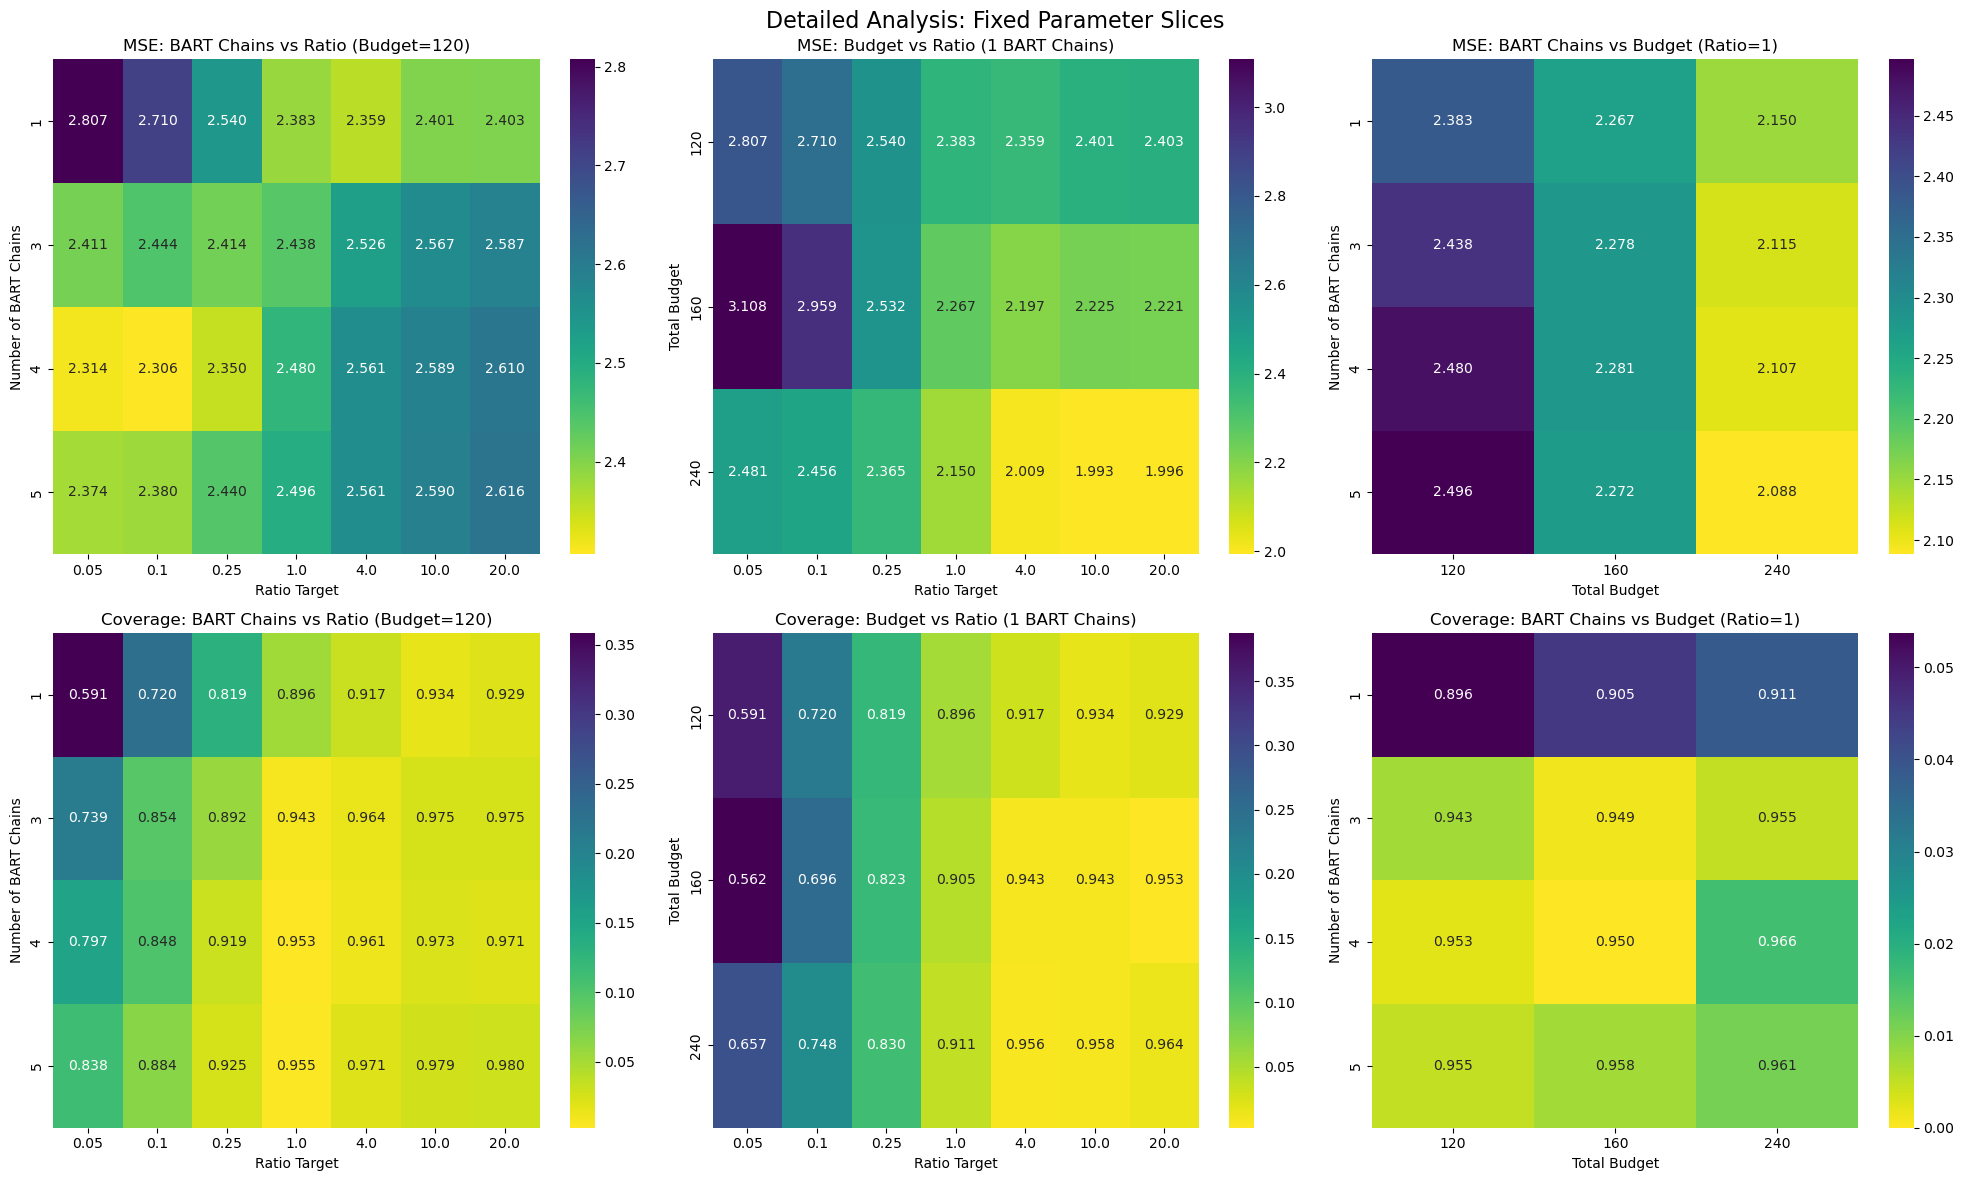

In [31]:
# Create detailed analysis plots for specific parameter values
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Detailed Analysis: Fixed Parameter Slices', fontsize=16)

# Fix total_budget=120 and show bart_num vs ratio_target
budget_fixed = 120
subset1 = results_df[results_df['total_budget'] == budget_fixed]
mse_detail1 = subset1.pivot(index='bart_num', columns='ratio_target', values='mse')
cov_detail1 = subset1.pivot(index='bart_num', columns='ratio_target', values='coverage')

sns.heatmap(mse_detail1, annot=True, fmt='.3f', cmap='viridis_r', ax=axes[0,0])
axes[0,0].set_title(f'MSE: BART Chains vs Ratio (Budget={budget_fixed})')
axes[0,0].set_xlabel('Ratio Target')
axes[0,0].set_ylabel('Number of BART Chains')

diff_detail_1 = (cov_detail1 - 0.95).abs()
sns.heatmap(diff_detail_1, annot=cov_detail1, fmt='.3f', cmap='viridis_r', ax=axes[1,0])
axes[1,0].set_title(f'Coverage: BART Chains vs Ratio (Budget={budget_fixed})')
axes[1,0].set_xlabel('Ratio Target')
axes[1,0].set_ylabel('Number of BART Chains')

# Fix bart_num=1 and show total_budget vs ratio_target
bart_fixed = 1
subset2 = results_df[results_df['bart_num'] == bart_fixed]
mse_detail2 = subset2.pivot(index='total_budget', columns='ratio_target', values='mse')
cov_detail2 = subset2.pivot(index='total_budget', columns='ratio_target', values='coverage')

sns.heatmap(mse_detail2, annot=True, fmt='.3f', cmap='viridis_r', ax=axes[0,1])
axes[0,1].set_title(f'MSE: Budget vs Ratio ({bart_fixed} BART Chains)')
axes[0,1].set_xlabel('Ratio Target')
axes[0,1].set_ylabel('Total Budget')

diff_detail_2 = (cov_detail2 - 0.95).abs()
sns.heatmap(diff_detail_2, annot=cov_detail2, fmt='.3f', cmap='viridis_r', ax=axes[1,1])
axes[1,1].set_title(f'Coverage: Budget vs Ratio ({bart_fixed} BART Chains)')
axes[1,1].set_xlabel('Ratio Target')
axes[1,1].set_ylabel('Total Budget')

# Fix ratio_target=1 and show bart_num vs total_budget
ratio_fixed = 1
subset3 = results_df[results_df['ratio_target'] == ratio_fixed]
mse_detail3 = subset3.pivot(index='bart_num', columns='total_budget', values='mse')
cov_detail3 = subset3.pivot(index='bart_num', columns='total_budget', values='coverage')

sns.heatmap(mse_detail3, annot=True, fmt='.3f', cmap='viridis_r', ax=axes[0,2])
axes[0,2].set_title(f'MSE: BART Chains vs Budget (Ratio={ratio_fixed})')
axes[0,2].set_xlabel('Total Budget')
axes[0,2].set_ylabel('Number of BART Chains')

diff_detail_3 = (cov_detail3 - 0.95).abs()
sns.heatmap(diff_detail_3, annot=cov_detail3, fmt='.3f', cmap='viridis_r', ax=axes[1,2])
axes[1,2].set_title(f'Coverage: BART Chains vs Budget (Ratio={ratio_fixed})')
axes[1,2].set_xlabel('Total Budget')
axes[1,2].set_ylabel('Number of BART Chains')

plt.tight_layout()
plt.show()

In [32]:
# Statistical analysis
print("\n" + "="*80)
print("STATISTICAL ANALYSIS")
print("="*80)

# Correlation analysis
print("Parameter Correlations with Performance:")
corr_data = results_df[['bart_num', 'total_budget', 'ratio_target', 'mse', 'coverage', 'pi_length']]
correlation_matrix = corr_data.corr()

print("\nCorrelation with MSE (lower is better):")
mse_corr = correlation_matrix['mse'].sort_values()
for param, corr in mse_corr.items():
    if param != 'mse':
        print(f"  {param}: {corr:.4f}")

print("\nCorrelation with Coverage (target: 0.95):")
cov_corr = correlation_matrix['coverage'].sort_values(ascending=False)
for param, corr in cov_corr.items():
    if param != 'coverage':
        print(f"  {param}: {corr:.4f}")

print("\nCorrelation with PI Length:")
pi_corr = correlation_matrix['pi_length'].sort_values()
for param, corr in pi_corr.items():
    if param != 'pi_length':
        print(f"  {param}: {corr:.4f}")

# Best performing parameter ranges
print(f"\nTop 10 configurations by MSE (lower is better):")
top_mse = results_df.nsmallest(10, 'mse')[['bart_num', 'total_budget', 'ratio_target', 'mse', 'coverage', 'pi_length']]
print(top_mse.to_string(index=False))

print(f"\nTop 10 configurations by Coverage (closest to 95%):")
results_df['coverage_diff'] = abs(results_df['coverage'] - 0.95)
top_coverage = results_df.nsmallest(10, 'coverage_diff')[['bart_num', 'total_budget', 'ratio_target', 'mse', 'coverage', 'pi_length']]
print(top_coverage.to_string(index=False))


STATISTICAL ANALYSIS
Parameter Correlations with Performance:

Correlation with MSE (lower is better):
  total_budget: -0.6273
  coverage: -0.4615
  bart_num: -0.1861
  pi_length: -0.1065
  ratio_target: 0.0614

Correlation with Coverage (target: 0.95):
  pi_length: 0.8956
  ratio_target: 0.4839
  bart_num: 0.4302
  total_budget: 0.1191
  mse: -0.4615

Correlation with PI Length:
  mse: -0.1065
  total_budget: -0.0487
  bart_num: 0.5535
  ratio_target: 0.6119
  coverage: 0.8956

Top 10 configurations by MSE (lower is better):
 bart_num  total_budget  ratio_target      mse  coverage  pi_length
        1           240         10.00 1.993001   0.95750   5.759197
        1           240         20.00 1.995989   0.96375   5.894959
        1           240          4.00 2.008865   0.95625   5.554580
        5           240          0.25 2.062703   0.95625   6.085935
        5           240          1.00 2.088394   0.96125   6.436837
        4           240          1.00 2.106655   0.96625   

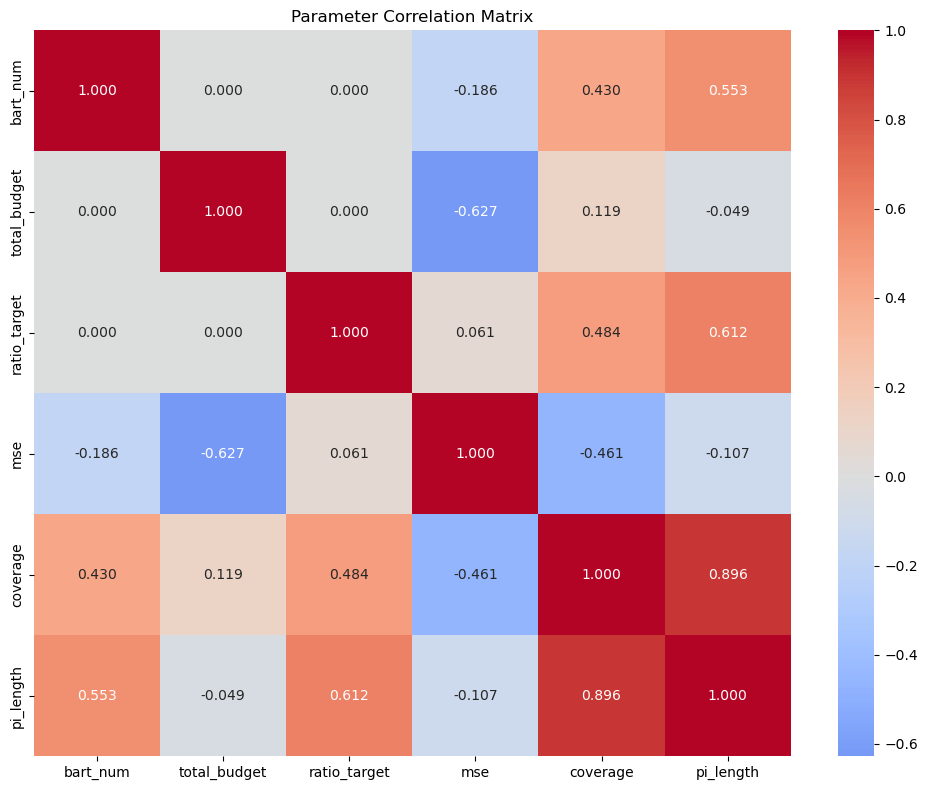

In [33]:
# Create correlation heatmap
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
correlation_matrix = results_df[['bart_num', 'total_budget', 'ratio_target', 'mse', 'coverage', 'pi_length']].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, ax=ax)
ax.set_title('Parameter Correlation Matrix')
plt.tight_layout()
plt.show()

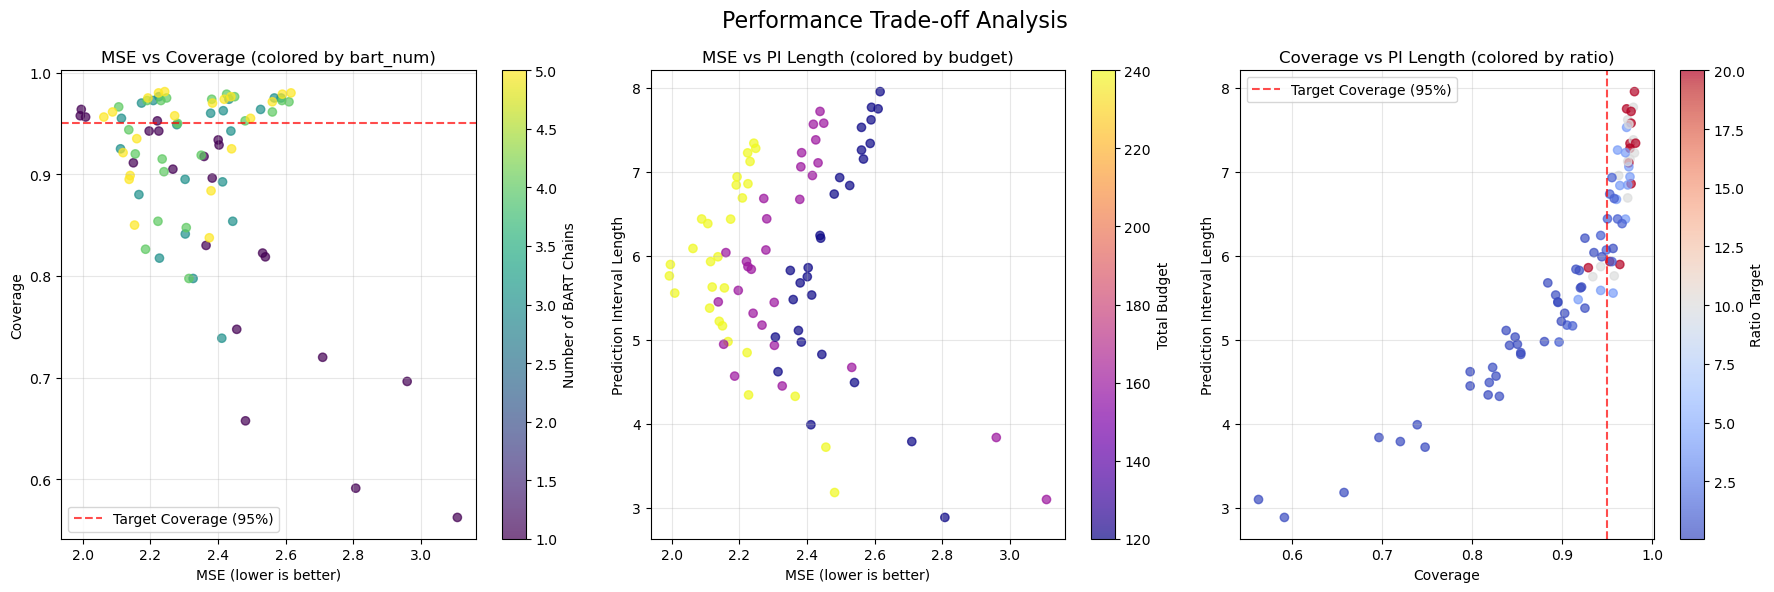

In [34]:
# Performance trade-off analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Performance Trade-off Analysis', fontsize=16)

# MSE vs Coverage scatter plot
scatter = axes[0].scatter(results_df['mse'], results_df['coverage'], 
                         c=results_df['bart_num'], cmap='viridis', alpha=0.7)
axes[0].set_xlabel('MSE (lower is better)')
axes[0].set_ylabel('Coverage')
axes[0].axhline(y=0.95, color='r', linestyle='--', alpha=0.7, label='Target Coverage (95%)')
axes[0].set_title('MSE vs Coverage (colored by bart_num)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0], label='Number of BART Chains')

# MSE vs PI Length scatter plot
scatter2 = axes[1].scatter(results_df['mse'], results_df['pi_length'], 
                          c=results_df['total_budget'], cmap='plasma', alpha=0.7)
axes[1].set_xlabel('MSE (lower is better)')
axes[1].set_ylabel('Prediction Interval Length')
axes[1].set_title('MSE vs PI Length (colored by budget)')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Total Budget')

# Coverage vs PI Length scatter plot
scatter3 = axes[2].scatter(results_df['coverage'], results_df['pi_length'], 
                          c=results_df['ratio_target'], cmap='coolwarm', alpha=0.7)
axes[2].set_xlabel('Coverage')
axes[2].set_ylabel('Prediction Interval Length')
axes[2].axvline(x=0.95, color='r', linestyle='--', alpha=0.7, label='Target Coverage (95%)')
axes[2].set_title('Coverage vs PI Length (colored by ratio)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[2], label='Ratio Target')

plt.tight_layout()
plt.show()

In [35]:
# Summary insights and recommendations
print("\n" + "="*80)
print("KEY INSIGHTS AND RECOMMENDATIONS")
print("="*80)

# Find optimal parameter combinations
best_mse_overall = results_df.loc[results_df['mse'].idxmin()]
best_coverage_overall = results_df.loc[results_df['coverage_diff'].idxmin()]
best_efficiency = results_df.loc[results_df.groupby('actual_budget')['mse'].idxmin()]

print("1. BEST OVERALL PERFORMANCE:")
print(f"   Best MSE: {best_mse_overall['mse']:.4f}, Coverage: {best_mse_overall['coverage']:.4f}")
print(f"   Configuration: bart_num={best_mse_overall['bart_num']}, budget={best_mse_overall['total_budget']}, ratio={best_mse_overall['ratio_target']}")

print(f"\n   Best Coverage: {best_coverage_overall['coverage']:.4f}, MSE: {best_coverage_overall['mse']:.4f}")
print(f"   Configuration: bart_num={best_coverage_overall['bart_num']}, budget={best_coverage_overall['total_budget']}, ratio={best_coverage_overall['ratio_target']}")

print("\n2. PARAMETER IMPACT ANALYSIS:")
# Group by each parameter and show impact
for param in ['bart_num', 'total_budget', 'ratio_target']:
    param_impact = results_df.groupby(param)['mse'].agg(['mean', 'std']).round(4)
    best_param_value = param_impact['mean'].idxmin()
    print(f"   {param}:")
    print(f"     Best value for MSE: {best_param_value} (avg MSE: {param_impact.loc[best_param_value, 'mean']:.4f})")
    print(f"     MSE range: {param_impact['mean'].min():.4f} - {param_impact['mean'].max():.4f}")

print("\n3. COMPUTATIONAL EFFICIENCY:")
efficiency_analysis = results_df.groupby('actual_budget')['mse'].min().sort_index()
print("   Best MSE by computational budget:")
for budget, mse in efficiency_analysis.items():
    best_config = results_df[(results_df['actual_budget'] == budget) & (results_df['mse'] == mse)].iloc[0]
    print(f"     Budget {budget}: MSE {mse:.4f} (bart_num={best_config['bart_num']}, ratio={best_config['ratio_target']}, coverage={best_config['coverage']:.3f})")

print("\n4. COVERAGE ANALYSIS:")
# Find configurations with good coverage (within 0.02 of 0.95)
good_coverage = results_df[abs(results_df['coverage'] - 0.95) <= 0.02]
if len(good_coverage) > 0:
    best_mse_good_coverage = good_coverage.loc[good_coverage['mse'].idxmin()]
    print(f"   Best MSE with good coverage (±2% of 95%): {best_mse_good_coverage['mse']:.4f}")
    print(f"   Coverage: {best_mse_good_coverage['coverage']:.4f}")
    print(f"   Configuration: bart_num={best_mse_good_coverage['bart_num']}, budget={best_mse_good_coverage['total_budget']}, ratio={best_mse_good_coverage['ratio_target']}")
else:
    print("   No configurations achieved coverage within ±2% of 95%")

print(f"\n5. TOTAL EXPERIMENTS: {len(results_df)} valid configurations")
print(f"   Grid search completed successfully!")
print(f"   Total computation time: {total_time:.2f} seconds")


KEY INSIGHTS AND RECOMMENDATIONS
1. BEST OVERALL PERFORMANCE:
   Best MSE: 1.9930, Coverage: 0.9575
   Configuration: bart_num=1.0, budget=240.0, ratio=10.0

   Best Coverage: 0.9500, MSE: 2.2808
   Configuration: bart_num=4.0, budget=160.0, ratio=1.0

2. PARAMETER IMPACT ANALYSIS:
   bart_num:
     Best value for MSE: 5 (avg MSE: 2.3092)
     MSE range: 2.3092 - 2.4077
   total_budget:
     Best value for MSE: 240 (avg MSE: 2.1800)
     MSE range: 2.1800 - 2.4878
   ratio_target:
     Best value for MSE: 1.0 (avg MSE: 2.2796)
     MSE range: 2.2796 - 2.3960

3. COMPUTATIONAL EFFICIENCY:
   Best MSE by computational budget:
     Budget 120: MSE 2.3063 (bart_num=4.0, ratio=0.1, coverage=0.848)
     Budget 159: MSE 2.2783 (bart_num=3.0, ratio=1.0, coverage=0.949)
     Budget 160: MSE 2.1375 (bart_num=5.0, ratio=0.1, coverage=0.895)
     Budget 240: MSE 1.9930 (bart_num=1.0, ratio=10.0, coverage=0.958)

4. COVERAGE ANALYSIS:
   Best MSE with good coverage (±2% of 95%): 1.9930
   Coverage